In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc2'

## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions

In [6]:
# shape of an image
img_size = 28
img_size_flat = img_size * img_size
img_shape = [img_size, img_size]

# number of classes
num_classes = 10

# number of color channels
num_channels = 1

## Helper functions

In [7]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    img_cnt = len(images)

    # some sanity checks on inputs
    assert img_cnt == len(cls_true)
    if cls_pred is not None:
        assert img_cnt == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(img_cnt)))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    empty_image = np.zeros(img_shape)

    for i, ax in enumerate(axes.flat):
        if i < img_cnt:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if cls_pred is not None:
                xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
            else:
                xlabel = 'True: {0}'.format(cls_true[i])
        
            ax.set_xlabel(xlabel)
        else:
            ax.imshow(empty_image, cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

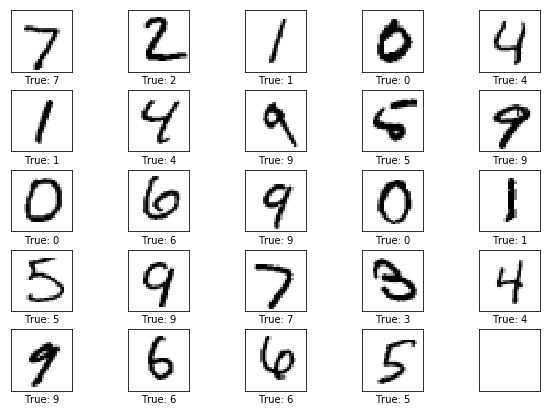

In [8]:
plot_images(data.test.images[0:24], data.test.cls[0:24])

# TensorFlow Graph

## Configuration of Neural Network

In [9]:
# convolutional layer 1: 16 filters of 5 x 5 pixels
filter_size1 = 5
num_filters1 = 16

# convolutional layer 2: 36 filters of 5 x 5 pixels
filter_size2 = 5
num_filters2 = 36

# fully-connected layer
fc_size = 128

## Helper functions for creating new variables

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Helper function for creating a new convolutional layer

In [11]:
def new_conv_layer(input,               # the previous layer
                   num_input_channels,  # number of channels in previous layer
                   filter_size,         # width and height of each filter
                   num_filters,         # number of filters
                   use_pooling=True):   # use 2x2 max pooling
    # shape of a filter weights
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # create weights and biases
    weights = new_weights(shape)
    biases = new_biases(num_filters)

    # create a convolutional layer
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases

    if use_pooling:
        # create 2x2 max-pooling layer with 2 pixels stride
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # create a ReLU unit
    # note, that ReLU is normally executed befor max-pooling
    # but since relu(max_pool(x)) == max_pool(relu(x))
    # we can save 75% of the relu operations
    layer = tf.nn.relu(layer)

    return layer, weights

## Helper function for flattening a layer

In [12]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    # assuming that layer_shape is [num_images, img_height, img_width, num_channels]
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

## Helper function for creating a fully-connected layer

In [13]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights([num_inputs, num_outputs])
    biases = new_biases(num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Placeholder variables

In [14]:
# flattened images as an input
x = tf.placeholder(tf.float32, [None, img_size_flat], name='x')

# reshape it to a tensor
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, [None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

## First convolutional layer

In [15]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

## Second convolutional layer

In [16]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

## Flatten layer

In [17]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat, num_features

(<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>, 1764)

## First fully-connected layer

In [18]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

## Second fully-connected layer

In [19]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

## Predicted class

In [20]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost function

In [21]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Opitmization method

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measures

In [23]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create a session

In [24]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform optimization iterations

In [25]:
train_batch_size = 64
total_iterations = 0

def optimize(iterations):
    global total_iterations

    for i in range(total_iterations, total_iterations + iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict)
            print('{0:>6}: training accuracy: {1:>6.1%}'.format(i, acc))
    
    total_iterations += iterations

## Helper functions to show performance

In [26]:
test_batch_size = 256

def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def plot_example_errors(cls_pred, correct, num_errors=16):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:num_errors],
                cls_true=cls_true[0:num_errors],
                cls_pred=cls_pred[0:num_errors])

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict={x: images, y_true: labels})
        i = j

    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    
    print('Accuracy on test-set: {0:.1%} ({1}/{2})'.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print('Example errors:')
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print('Confusion matrix:')
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization

Accuracy on test-set: 8.7% (871/10000)
Confusion matrix:
[[   0    0    0    0    0  980    0    0    0    0]
 [   0    0    0    0    0 1134    0    1    0    0]
 [   0    0    0    0    0 1032    0    0    0    0]
 [   0    0    0    0    0 1010    0    0    0    0]
 [   0    0    0    0    0  981    0    1    0    0]
 [   0    0    0    0    0  871    0   21    0    0]
 [   0    0    0    0    0  958    0    0    0    0]
 [   0    0    0    0    0 1028    0    0    0    0]
 [   0    0    0    0    0  972    0    2    0    0]
 [   0    0    0    0    0 1009    0    0    0    0]]


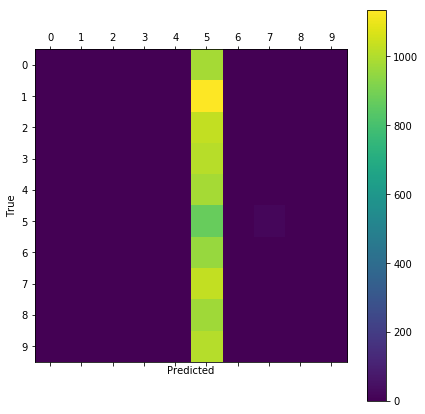

In [27]:
print_test_accuracy(show_confusion_matrix=True)

## Performance after one iteration

In [28]:
optimize(iterations=1)

     0: training accuracy:   1.6%


Accuracy on test-set: 7.8% (775/10000)
Confusion matrix:
[[   0    0    0    0    0  974    0    6    0    0]
 [   0    0    0    0   11 1082    0   42    0    0]
 [   0    0    0    0    0 1021    0   11    0    0]
 [   0    0    0    0    0 1001    0    9    0    0]
 [   0    0    0    0    2  960    0   20    0    0]
 [   0    0    0    0    0  772    0  120    0    0]
 [   0    0    0    0    0  955    0    3    0    0]
 [   0    0    0    0    0 1027    0    1    0    0]
 [   0    0    0    0    0  942    0   32    0    0]
 [   0    0    0    0    0 1004    0    5    0    0]]


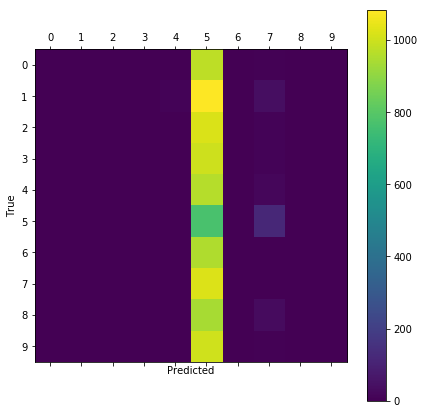

In [29]:
print_test_accuracy(show_confusion_matrix=True)

## Performance after 100 iterations

In [30]:
optimize(iterations=90)

Accuracy on test-set: 63.1% (6307/10000)
Confusion matrix:
[[ 932    0    0   10    0    0    5    3   30    0]
 [   0 1082    2   48    0    0    1    0    2    0]
 [ 108   29  517  275   14    0    3   47   39    0]
 [  36    7    9  893    0    0    0   43   22    0]
 [  18   25    2   55  740    0   22  103   15    2]
 [ 137   32    0  361    7    0    6  185  164    0]
 [ 191   30    1   63   20    0  556    2   95    0]
 [   6   49   16   15    1    0    0  939    2    0]
 [  71   45    3  154    4    0    0   87  610    0]
 [  34   24    2   80  241    0    4  573   13   38]]


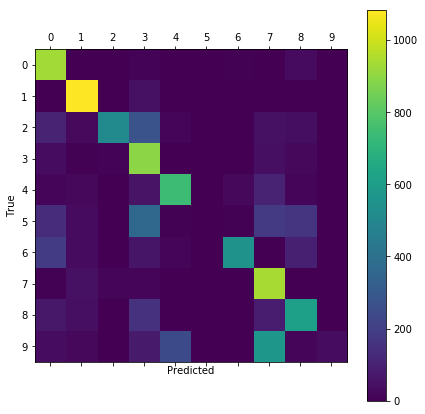

In [31]:
print_test_accuracy(show_confusion_matrix=True)

## Performance after 1000 iterations

In [32]:
optimize(iterations=900)

   100: training accuracy:  62.5%
   200: training accuracy:  81.2%
   300: training accuracy:  89.1%
   400: training accuracy:  85.9%
   500: training accuracy:  82.8%
   600: training accuracy:  93.8%
   700: training accuracy:  93.8%
   800: training accuracy:  92.2%
   900: training accuracy:  90.6%


Accuracy on test-set: 93.5% (9352/10000)
Example errors:


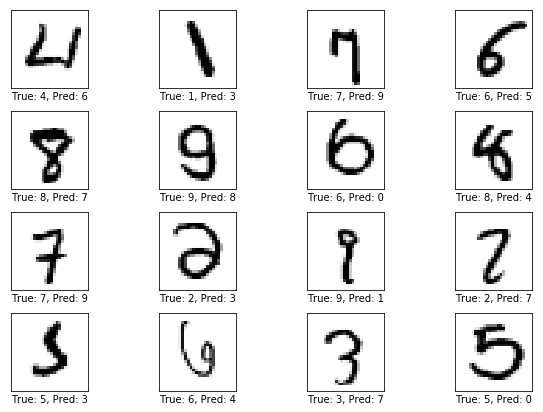

Confusion matrix:
[[ 964    0    1    0    0    2    6    1    6    0]
 [   0 1109    4    3    1    0    4    0   14    0]
 [  14    2  921   20   13    1    9   15   33    4]
 [   4    2    8  953    0    6    0   13   18    6]
 [   1    1    2    1  922    0   11    1    4   39]
 [  10    1    1   32    5  795   17    2   21    8]
 [  11    4    2    0    9   14  915    1    2    0]
 [   1    7   21    6    4    0    0  930    2   57]
 [   8    2    1   19   10    8    7    9  896   14]
 [  10    6    3   10   15    2    0    9    7  947]]


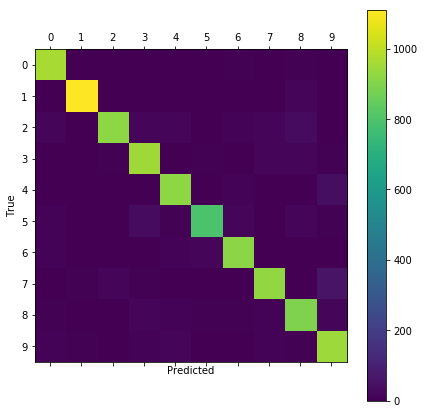

In [33]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Performance after 10000 iterations

In [34]:
optimize(iterations=9000)

  1000: training accuracy:  96.9%
  1100: training accuracy:  90.6%
  1200: training accuracy:  98.4%
  1300: training accuracy:  95.3%
  1400: training accuracy:  96.9%
  1500: training accuracy:  96.9%
  1600: training accuracy:  95.3%
  1700: training accuracy:  92.2%
  1800: training accuracy:  96.9%
  1900: training accuracy: 100.0%


KeyboardInterrupt: 

Accuracy on test-set: 96.5% (9653/10000)
Example errors:


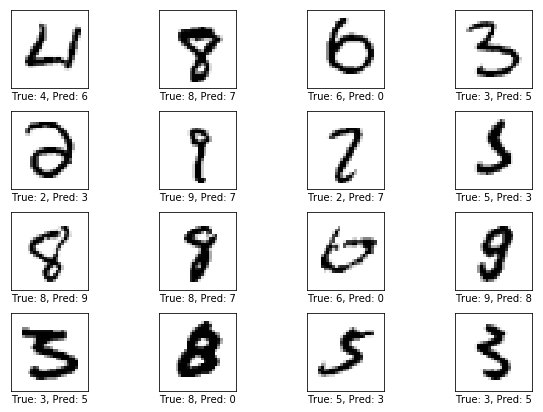

Confusion matrix:
[[ 969    0    1    0    0    1    5    1    3    0]
 [   0 1118    4    1    1    0    4    0    7    0]
 [  11    1  980    9    6    0    1   11   13    0]
 [   1    0    3  975    0    9    0    9   12    1]
 [   1    1    2    0  953    0    5    2    2   16]
 [   6    1    0   11    1  857    6    1    5    4]
 [  10    3    1    0    5    5  932    0    2    0]
 [   1    5   17    3    1    1    0  988    0   12]
 [   8    0    2    7    5    1    2   11  930    8]
 [  11    6    1    6   15    2    0   11    6  951]]


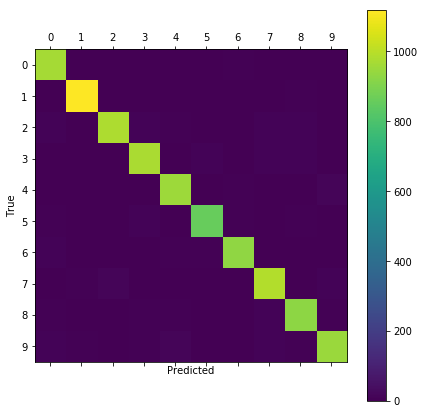

In [35]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [1]:
# close TensorFlow session
#session.close()